In [44]:
import sys
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append("..")
from utils.search_rainfalls import search_rainfalls
from utils.time_series_utils import get_time_series_df, get_compare_by_time_df, check_abnormally_stable_value_station, check_extreme_value_station

In [2]:
df = search_rainfalls()
df.head()

,index,date,start_time,peak_time,end_time,duration minutes,max_rainfall
0,115,2020-08-01,3-40,5-0,7-10,210,88.0
1,176,2020-10-12,6-10,8-10,9-40,210,82.0
2,106,2020-07-27,10-50,12-20,13-40,170,80.0
3,95,2020-07-12,21-10,22-0,23-20,130,76.5
4,144,2020-09-14,4-50,6-0,7-0,130,76.0


In [38]:
strong_rainfalls = df.loc[df["max_rainfall"] > 40]

In [39]:
sys.path.append("../../")
from common.utils import timestep_csv_names

_timestep_csv_names = timestep_csv_names(delta=10)
target_data = {}
for idx in strong_rainfalls.index:
    date = strong_rainfalls.loc[idx, "date"]
    peak_time = strong_rainfalls.loc[idx, "peak_time"]
    peak_time_idx = _timestep_csv_names.index(f"{peak_time}.csv")
    # 2 hours before and after of peak_time
    start_idx, end_idx = peak_time_idx - 18, peak_time_idx + 18
    if start_idx < 0 or end_idx > len(_timestep_csv_names) - 1:
        print(f"{date} is skipped. (start: {start_idx}, end: {end_idx})")
        continue
    target_data[date] = {"start_time": _timestep_csv_names[start_idx].replace(".csv", ""), "end_time": _timestep_csv_names[end_idx].replace(".csv", "")}

2020-07-12 is skipped. (start: 114, end: 150)


In [40]:
import pandas as pd


def convert_time_from_int(int_time: int) -> str:
    str_time = str(int_time)
    return str_time[:-2] + ":" + str_time[-2:]


def reset_time_from_str(x: str, str_time_series: list) -> str:
    center_idx = len(str_time_series) // 2
    time_idx = str_time_series.index(x)
    # if time_idx > center_idx:
    #     time = f"t+{10 * (time_idx - center_idx)}"
    # elif time_idx < center_idx:
    #     time = f"t-{10 * (center_idx - time_idx)}"
    # else:
    #     time = 0
    return 10 * (time_idx - center_idx)


data_df = pd.DataFrame(columns=["Time", "ParamName", "Value", "Station_Name", "date"])
for date in target_data.keys():
    year, month, day = date.split("-")
    time_series_df = get_time_series_df(
        one_day_data_dir_path="../../../data/one_day_data",
        year=year,
        month=month,
        date=day,
        start_time=target_data[date]["start_time"],
        end_time=target_data[date]["end_time"],
    )
    compare_df = get_compare_by_time_df(time_series_df, set_zero_start=True)
    # Reset Time
    unique_times = compare_df["Time"].unique()
    sorted_unique_times = sorted([int(t.replace(":", "")) for t in unique_times])
    sorted_unique_times = [convert_time_from_int(t) for t in sorted_unique_times]
    compare_df["Time"] = compare_df["Time"].apply(reset_time_from_str, args=(sorted_unique_times,))
    # Add date col for hue
    compare_df["date"] = date
    data_df = pd.concat([data_df, compare_df], axis=0, ignore_index=True)

In [41]:
data_df.head()

,Time,ParamName,Value,Station_Name,date
0,-180,hour-rain,0.0,Vlz-Bagbaguin_00174731,2020-08-01
1,-180,hour-rain,0.0,QC-SciHS_00181271,2020-08-01
2,-180,hour-rain,0.0,Vlz-Punturin_00174725,2020-08-01
3,-180,hour-rain,0.0,DOST_00174730,2020-08-01
4,-180,hour-rain,0.0,Xavier-Sch_00181285,2020-08-01


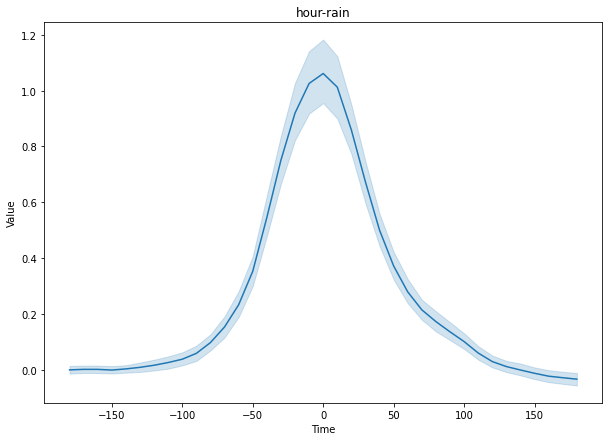

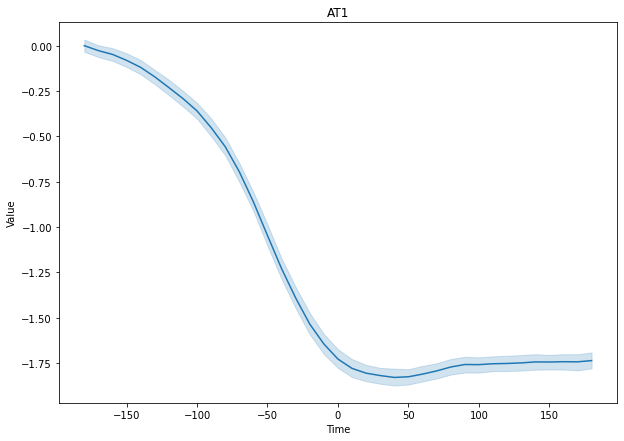

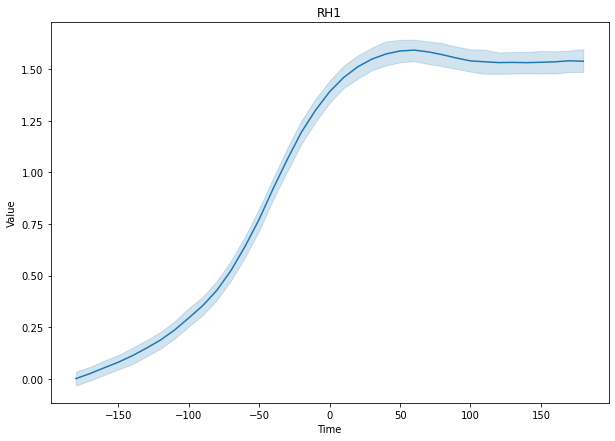

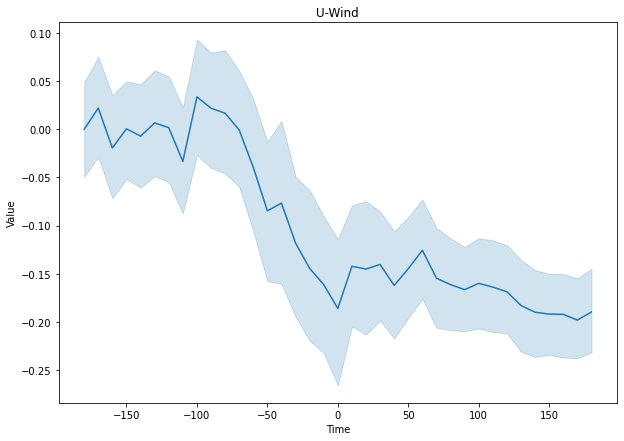

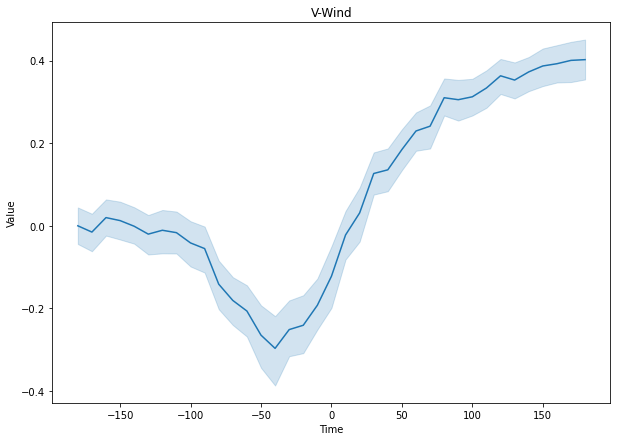

In [42]:
for col in ["hour-rain", "AT1", "RH1", "U-Wind", "V-Wind"]:
    fig, ax = plt.subplots(figsize=(10, 7))
    ax = sns.lineplot(data=data_df.loc[data_df["ParamName"] == col], x="Time", y="Value")
    ax.set_title(col)
    # ax.get_legend().remove()
    plt.show()
    plt.close()

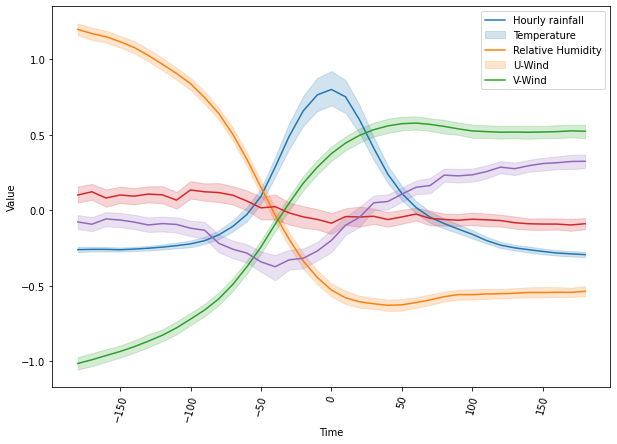

In [56]:
target_cols = ["hour-rain", "AT1", "RH1", "U-Wind", "V-Wind"]
fig, ax = plt.subplots(figsize=(10, 7))
# for station_name, grouped_df in compare_df.groupby(by=["Station_Name"]):
#     if station_name not in exclude_observation_points:
#         sns.lineplot(data=grouped_df, x="Time", y="Value", hue="ParamName", hue_order=target_col, ax=ax)

# exclude_observation_points=["MM-EFCOS_00173456", "CentPark_00181288", "Vlz-DRRMO_00174734", "MM-Libertad_00181289"]
# compare_df = compare_df.loc[~compare_df["Station_Name"].isin([exclude_observation_points])]
ax = sns.lineplot(data=data_df, x="Time", y="Value", hue="ParamName", hue_order=target_cols, ax=ax)
ax.legend(["Hourly rainfall", "Temperature", "Relative Humidity", "U-Wind", "V-Wind"])
plt.xticks(rotation=75)
plt.show()
plt.close()

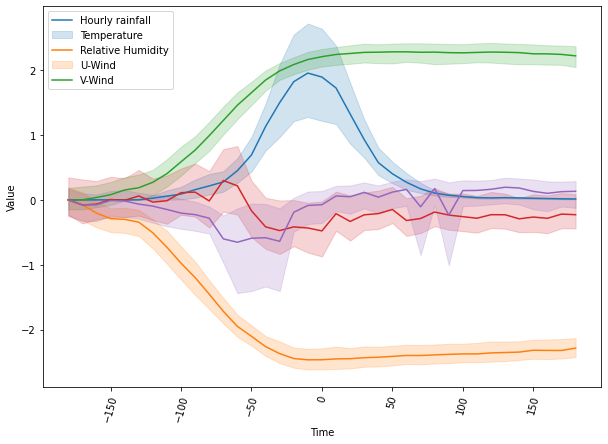

In [51]:
target_cols = ["hour-rain", "AT1", "RH1", "U-Wind", "V-Wind"]
fig, ax = plt.subplots(figsize=(10, 7))
# for station_name, grouped_df in compare_df.groupby(by=["Station_Name"]):
#     if station_name not in exclude_observation_points:
#         sns.lineplot(data=grouped_df, x="Time", y="Value", hue="ParamName", hue_order=target_col, ax=ax)

# exclude_observation_points=["MM-EFCOS_00173456", "CentPark_00181288", "Vlz-DRRMO_00174734", "MM-Libertad_00181289"]
# compare_df = compare_df.loc[~compare_df["Station_Name"].isin([exclude_observation_points])]
ax = sns.lineplot(data=data_df.loc[data_df["date"] == "2020-10-12"], x="Time", y="Value", hue="ParamName", hue_order=target_cols, ax=ax)
ax.legend(["Hourly rainfall", "Temperature", "Relative Humidity", "U-Wind", "V-Wind"])
plt.xticks(rotation=75)
plt.show()
plt.close()

In [52]:
data_df = pd.DataFrame(columns=["Time", "ParamName", "Value", "Station_Name", "date"])
for date in target_data.keys():
    year, month, day = date.split("-")
    time_series_df = get_time_series_df(
        one_day_data_dir_path="../../../data/one_day_data",
        year=year,
        month=month,
        date=day,
        start_time=target_data[date]["start_time"],
        end_time=target_data[date]["end_time"],
    )
    compare_df = get_compare_by_time_df(time_series_df, set_zero_start=False)
    # Reset Time
    unique_times = compare_df["Time"].unique()
    sorted_unique_times = sorted([int(t.replace(":", "")) for t in unique_times])
    sorted_unique_times = [convert_time_from_int(t) for t in sorted_unique_times]
    compare_df["Time"] = compare_df["Time"].apply(reset_time_from_str, args=(sorted_unique_times,))
    # Add date col for hue
    compare_df["date"] = date
    data_df = pd.concat([data_df, compare_df], axis=0, ignore_index=True)

In [53]:
data_df.head()

,Time,ParamName,Value,Station_Name,date
0,-180,hour-rain,-0.478201,Vlz-Bagbaguin_00174731,2020-08-01
1,-180,hour-rain,-0.478201,QC-SciHS_00181271,2020-08-01
2,-180,hour-rain,-0.478201,Vlz-Punturin_00174725,2020-08-01
3,-180,hour-rain,-0.478201,DOST_00174730,2020-08-01
4,-180,hour-rain,-0.478201,Xavier-Sch_00181285,2020-08-01


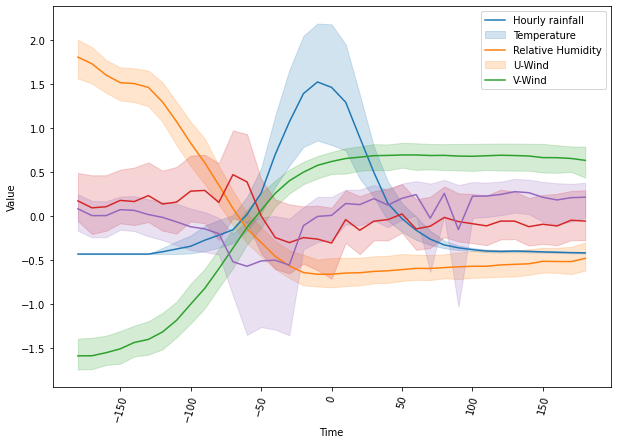

In [54]:
target_cols = ["hour-rain", "AT1", "RH1", "U-Wind", "V-Wind"]
fig, ax = plt.subplots(figsize=(10, 7))
# for station_name, grouped_df in compare_df.groupby(by=["Station_Name"]):
#     if station_name not in exclude_observation_points:
#         sns.lineplot(data=grouped_df, x="Time", y="Value", hue="ParamName", hue_order=target_col, ax=ax)

# exclude_observation_points=["MM-EFCOS_00173456", "CentPark_00181288", "Vlz-DRRMO_00174734", "MM-Libertad_00181289"]
# compare_df = compare_df.loc[~compare_df["Station_Name"].isin([exclude_observation_points])]
ax = sns.lineplot(data=data_df.loc[data_df["date"] == "2020-10-12"], x="Time", y="Value", hue="ParamName", hue_order=target_cols, ax=ax)
ax.legend(["Hourly rainfall", "Temperature", "Relative Humidity", "U-Wind", "V-Wind"])
plt.xticks(rotation=75)
plt.show()
plt.close()

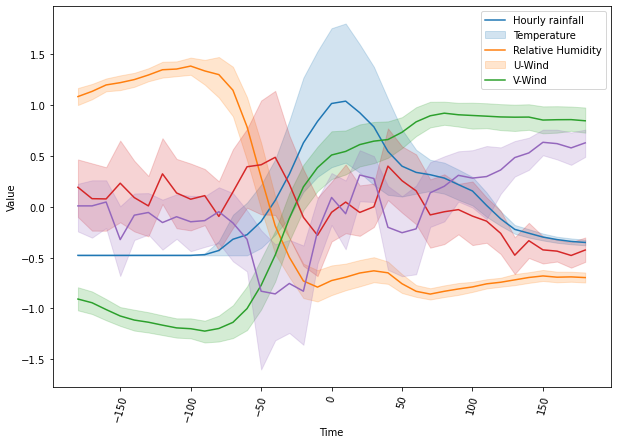

In [55]:
target_cols = ["hour-rain", "AT1", "RH1", "U-Wind", "V-Wind"]
fig, ax = plt.subplots(figsize=(10, 7))
# for station_name, grouped_df in compare_df.groupby(by=["Station_Name"]):
#     if station_name not in exclude_observation_points:
#         sns.lineplot(data=grouped_df, x="Time", y="Value", hue="ParamName", hue_order=target_col, ax=ax)

# exclude_observation_points=["MM-EFCOS_00173456", "CentPark_00181288", "Vlz-DRRMO_00174734", "MM-Libertad_00181289"]
# compare_df = compare_df.loc[~compare_df["Station_Name"].isin([exclude_observation_points])]
ax = sns.lineplot(data=data_df.loc[data_df["date"] == "2020-08-01"], x="Time", y="Value", hue="ParamName", hue_order=target_cols, ax=ax)
ax.legend(["Hourly rainfall", "Temperature", "Relative Humidity", "U-Wind", "V-Wind"])
plt.xticks(rotation=75)
plt.show()
plt.close()

In [62]:
# difference 
data_df["diff"] = data_df.groupby(by=["date", "Station_Name", "ParamName"])["Value"].diff()
data_df.head()

,Time,ParamName,Value,Station_Name,date,diff
0,-180,hour-rain,-0.478201,Vlz-Bagbaguin_00174731,2020-08-01,NaN
1,-180,hour-rain,-0.478201,QC-SciHS_00181271,2020-08-01,NaN
2,-180,hour-rain,-0.478201,Vlz-Punturin_00174725,2020-08-01,NaN
3,-180,hour-rain,-0.478201,DOST_00174730,2020-08-01,NaN
4,-180,hour-rain,-0.478201,Xavier-Sch_00181285,2020-08-01,NaN


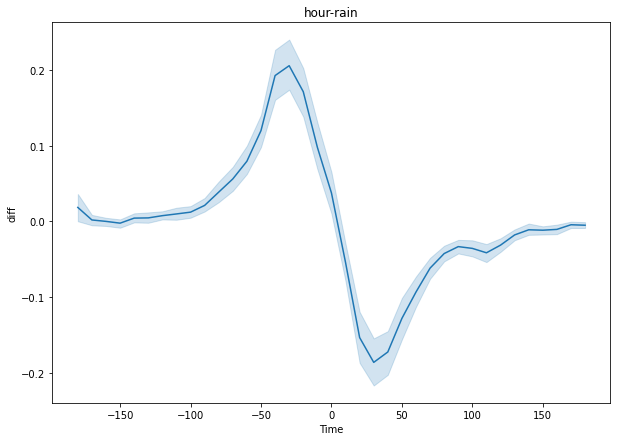

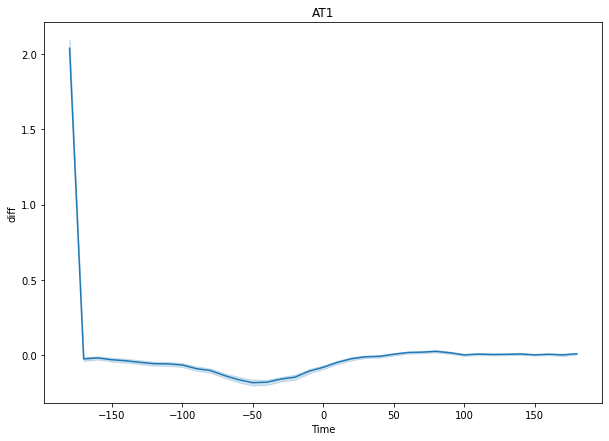

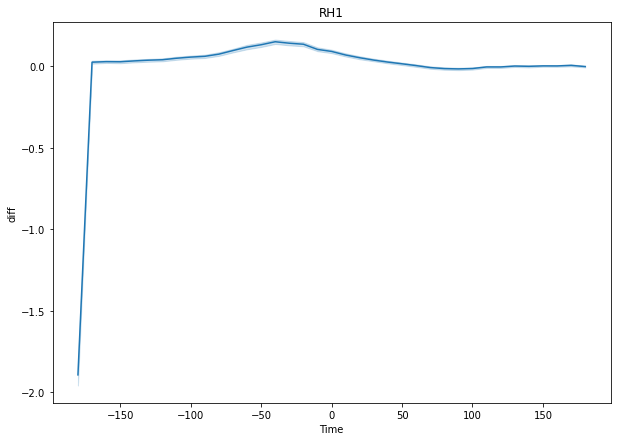

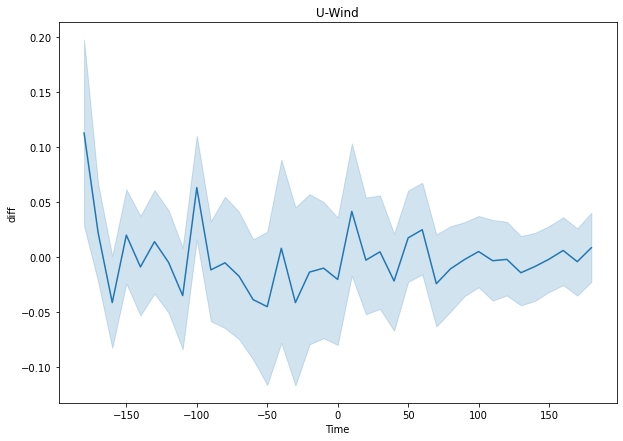

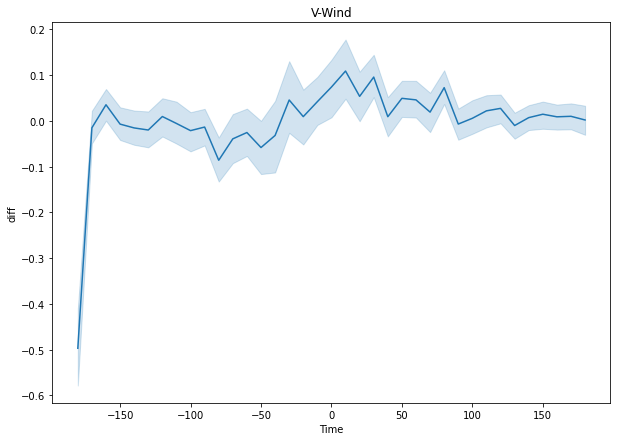

In [68]:
for col in ["hour-rain", "AT1", "RH1", "U-Wind", "V-Wind"]:
    fig, ax = plt.subplots(figsize=(10, 7))
    ax = sns.lineplot(data=data_df.loc[data_df["ParamName"] == col], x="Time", y="diff")
    ax.set_title(col)
    # ax.get_legend().remove()
    plt.show()
    plt.close()

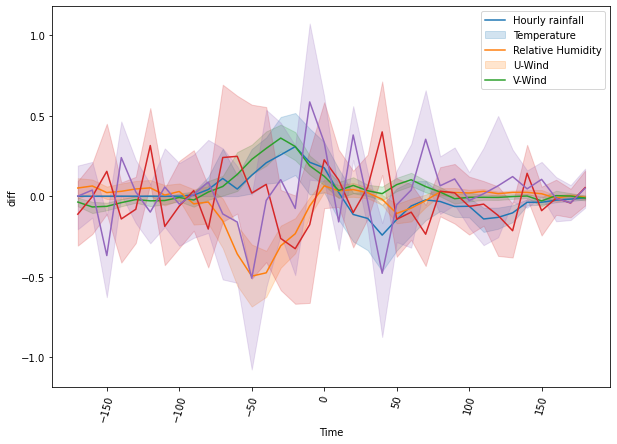

In [67]:
target_cols = ["hour-rain", "AT1", "RH1", "U-Wind", "V-Wind"]
fig, ax = plt.subplots(figsize=(10, 7))
# for station_name, grouped_df in compare_df.groupby(by=["Station_Name"]):
#     if station_name not in exclude_observation_points:
#         sns.lineplot(data=grouped_df, x="Time", y="Value", hue="ParamName", hue_order=target_col, ax=ax)

# exclude_observation_points=["MM-EFCOS_00173456", "CentPark_00181288", "Vlz-DRRMO_00174734", "MM-Libertad_00181289"]
# compare_df = compare_df.loc[~compare_df["Station_Name"].isin([exclude_observation_points])]
ax = sns.lineplot(data=data_df.loc[data_df["date"] == "2020-08-01"], x="Time", y="diff", hue="ParamName", hue_order=target_cols, ax=ax)
ax.legend(["Hourly rainfall", "Temperature", "Relative Humidity", "U-Wind", "V-Wind"])
plt.xticks(rotation=75)
plt.show()
plt.close()

In [69]:
data_df.loc[data_df["ParamName"] == "AT1"].describe()

,Value,diff
count,4.769300e+04,46404.000000
mean,-1.489826e-17,-0.017059
std,9.995806e-01,0.352560
min,-4.377890e+00,-3.557609
25%,-7.650695e-01,-0.098772
50%,-2.007896e-01,0.000000
75%,8.162989e-01,0.050966
max,4.297556e+00,4.431062
